# Music genre classification scripts and functions used

by Tony Lung Ca Hin, 201905921 and Laura Horsfall Folmer 201905054 Aarhus University 17-12-2021.

In [1]:
import torch
import torchaudio
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor,transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import Dataset, DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import os
import pathlib
import numpy as np
from IPython.display import Audio, display
import librosa
import librosa.display
import sklearn
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.image as mpimg
import neptune.new as neptune

# Help function to plot .wav

In [8]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

# Transforming training data

In [3]:
data_path = 'Data/genres'

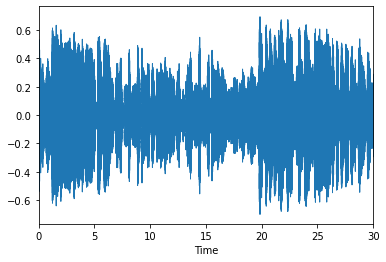

In [4]:
waveform, sample_rate = librosa.load(data_path + '/jazz/jazz.00043.wav')
librosa.display.waveplot(waveform, sample_rate)
plt.show()

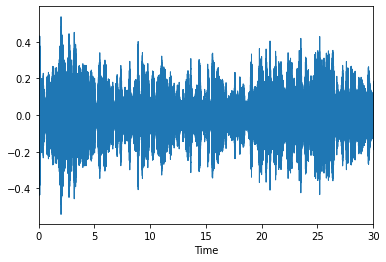

In [5]:
waveform_shift = librosa.effects.pitch_shift(waveform, sample_rate, n_steps=-9)
librosa.display.waveplot(waveform_shift, sample_rate)
plt.show()

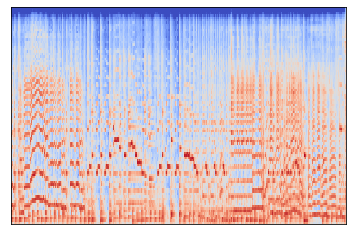

In [6]:
spec = librosa.feature.melspectrogram(waveform, sr=sample_rate, n_fft = 2048, win_length=2048, n_mels=90, hop_length=1024)
spec = librosa.power_to_db(spec)
librosa.display.specshow(spec,sr=sample_rate,cmap="coolwarm")
plt.savefig(f'jazz.00096.png', bbox_inches = 'tight')

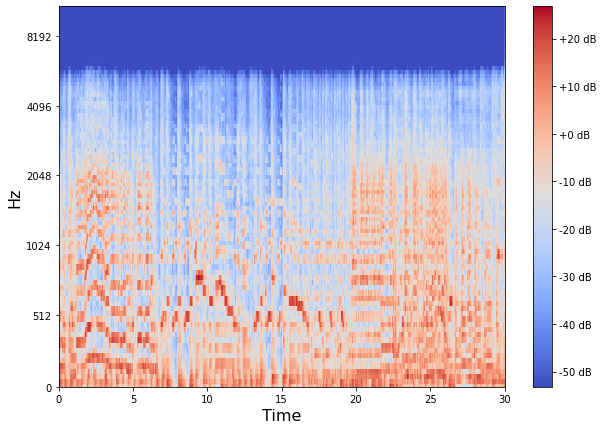

In [7]:
spec = librosa.feature.melspectrogram(waveform_shift, sr=sample_rate, n_fft = 2048, win_length=2048, n_mels=90, hop_length=512)
spec = librosa.power_to_db(spec)
plt.figure(figsize=(10,7))
librosa.display.specshow(spec,
                        x_axis='time',
                        y_axis='mel',
                        sr=sample_rate,
                        cmap="coolwarm")
#plt.title('Jazz', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Hz', fontsize=16)
plt.colorbar(format='%+2.0f dB')
plt.savefig(f'jazz.00043_shifted.png', bbox_inches = 'tight')

In [14]:
Audio(waveform, rate=sample_rate)

In [15]:
Audio(waveform_shift, rate=sample_rate)

# Pipeline for creating shorter .wav files

In [31]:
def smaller_audio(genres, data_path, audio_path, chunk_size):
    for g in genres:
        pathlib.Path(f'{audio_path}/{g}').mkdir(parents=True, exist_ok=True)
        for filename in os.listdir(f'{data_path}/{g}'):
            songname = f'{data_path}/{g}/{filename}'
            waveform, sample_rate = torchaudio.load(songname)
            for idx, split in enumerate(torch.chunk(waveform[0], chunk_size)): #Splitting audio file into chunk_size
                torchaudio.save(f'{audio_path}/{g}/{filename[:-3].replace(".", "")}{idx}.wav', split.unsqueeze(dim = 0), 
                                sample_rate, encoding="PCM_S", bits_per_sample=16) #Saving same 16 bit, from pyaudio tutorial

In [32]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
data_path = 'Data/genres'
audio_path = 'Data/small_genres'
chunk_size = 5
#smaller_audio(genres, data_path, audio_path, chunk_size)

# Pipeline for generating MelSpectograms:

**Parameters:**

*n_fft* = Fast fourier transform. The frame size; number of samples we consider in each chunk of the signal when we segment the signal. Creates n_fft // 2 + 1 bins. Typical value 2048.

*win_length* = Window size. Amount of samples we apply windowing to. Default value is same as n_fft. We set it to default.

*n_mels* = number of mel filter banks.

*hop_length* = Slide size. Makes the windows overlap. Think of convolution. 

In [33]:
def make_libmelspecs(genres, data_path, img_path):
    for g in genres:
        pathlib.Path(f'{img_path}/{g}').mkdir(parents=True, exist_ok=True)
        for filename in os.listdir(f'{data_path}/{g}'):
            songname = f'{data_path}/{g}/{filename}'
            waveform, sample_rate = librosa.load(songname)
            spec = librosa.feature.melspectrogram(waveform, sr=sample_rate, n_fft = 2048, win_length=2048, n_mels=90, hop_length=1024)
            spec = librosa.power_to_db(spec)
            librosa.display.specshow(spec,sr=sample_rate,cmap="coolwarm")
            plt.axis('off');
            plt.savefig(f'{img_path}/{g}/{filename[:-3].replace(".", "")}.png', bbox_inches = 'tight') #bbox removes white border
            plt.clf()

In [170]:
data_path = 'Data/genres'
img_path = 'Data/images'
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
#make_libmelspecs(genres, data_path, img_path)

# Showing the transformed data:

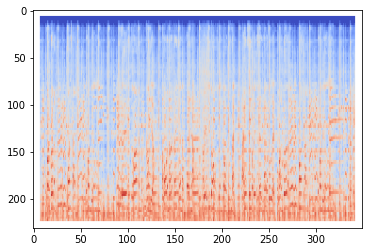

In [172]:
melspec = mpimg.imread(img_path + '/blues/blues00000.png')
plt.imshow(melspec)
plt.show()

# Dataset

In [173]:
def save_tensors(dataset, folder):
    pathlib.Path(folder+'/images').mkdir(parents=True, exist_ok=True) #Creating folders
    pathlib.Path(folder+'/labels').mkdir(parents=True, exist_ok=True)
    for idx, data in enumerate(dataset): #Saving transformed input as tensors
        im, lab = data
        torch.save(im, folder+'/images/image{}'.format(idx))
        torch.save(lab, folder+'/labels/label{}'.format(idx))

In [174]:
class Spectrogram_dataset(Dataset):
    def __init__(self, folder, transform=None): # Path to folder
        self.img_dir = folder + '/images'
        self.lab_dir = folder + '/labels'
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir)) #Just the amount of elements in either directory

    def __getitem__(self, idx):
        lst_img = sorted(os.listdir(self.img_dir)) #Files are named in same manner, so sorting should give same indices.
        lst_label = sorted(os.listdir(self.lab_dir))

        img_file_path = os.path.join(self.img_dir, lst_img[idx])
        img_tensor = torch.load(img_file_path)

        label_file_path = os.path.join(self.lab_dir, lst_label[idx])
        label = torch.load(label_file_path)

        return img_tensor, label

# Creating and loading the data

## 1000 samples, 30 sec songs.

In [175]:
img_path = 'Data/images'
resize = 224
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((resize,resize)), 
                                            torchvision.transforms.ToTensor(),])


dataset = torchvision.datasets.ImageFolder(root = img_path, transform=transform)
#Using ImageFolder will generate (sample, target) with folder name as target
print(dataset)
print(dataset.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: Data/images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


### Splitting dataset before saving tensors

In [176]:
train, val, test = random_split(dataset, [800, 100, 100], generator=torch.Generator().manual_seed(42))

In [177]:
train_path = 'train/30secs/tensors'
val_path = 'val/30secs/tensors'
test_path = 'test/30secs/tensors'

#save_tensors(train, train_path)
#save_tensors(val, val_path)
#save_tensors(test, test_path)

## Loading tensors with custom dataset function

In [178]:
train = Spectrogram_dataset(train_path)
val = Spectrogram_dataset(val_path)
test = Spectrogram_dataset(test_path)

print(len(train))
print(len(val))
print(len(test))

800
100
100


## Dataloaders

In [148]:
batch_size = 100
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test, batch_size=batch_size, shuffle=True)
#[batchsize, channels, height, width], label

# Logging with neptune

In [150]:
run = neptune.init(
    project="mgc-tora/Final-runs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDhhMWMyNy05YTZlLTRiM2EtYjgzYi1lYTFhZmZlZmNjMzkifQ==",
) 

https://app.neptune.ai/mgc-tora/Final-runs/e/FIN-1
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Defining our CNN network:

In [151]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=12)
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(in_features=12*53*53, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1, 12*53*53)
        x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

model = Net()

print('Network architecture:\n')
print(model)

# Print parameter shapes
print('Network parameters:\n')
for name, param in model.named_parameters(): 
    print('parameter',name,param.shape)
    
model.to(device)

Network architecture:

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=33708, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)
Network parameters:

parameter conv1.weight torch.Size([6, 3, 5, 5])
parameter conv1.bias torch.Size([6])
parameter bn1.weight torch.Size([6])
parameter bn1.bias torch.Size([6])
parameter conv2.weight torch.Size([12, 6, 5, 5])
parameter conv2.bias torch.Size([12])
parameter bn2.weight torch.Size([12])
parameter bn2.bias torch.Size([12])
parameter fc1.weight torch.Size([1024, 33708])
parameter fc1.bias torch.Size([1024]

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=33708, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

# CNN with 1000 samples unaugmented

In [152]:
def accuracy_score(targets, predictions):
    return 1.0*np.sum((np.array(targets) == np.array(predictions)))/len(targets)

Epoch  1 : Train Loss 2.536431 , Val Loss 0.022802, Train acc 0.222500, Valid acc 0.240000
Epoch  2 : Train Loss 1.770464 , Val Loss 0.022553, Train acc 0.207500, Valid acc 0.180000
Epoch  3 : Train Loss 1.435925 , Val Loss 0.021629, Train acc 0.193750, Valid acc 0.130000
Epoch  4 : Train Loss 1.168332 , Val Loss 0.019822, Train acc 0.338750, Valid acc 0.230000
Epoch  5 : Train Loss 0.999543 , Val Loss 0.017079, Train acc 0.592500, Valid acc 0.410000
Epoch  6 : Train Loss 0.832394 , Val Loss 0.014421, Train acc 0.828750, Valid acc 0.630000
Epoch  7 : Train Loss 0.708143 , Val Loss 0.013306, Train acc 0.866250, Valid acc 0.600000
Epoch  8 : Train Loss 0.584005 , Val Loss 0.012357, Train acc 0.905000, Valid acc 0.540000
Epoch  9 : Train Loss 0.486418 , Val Loss 0.011223, Train acc 0.950000, Valid acc 0.640000
Epoch 10 : Train Loss 0.419741 , Val Loss 0.010061, Train acc 0.983750, Valid acc 0.700000
Epoch 11 : Train Loss 0.356314 , Val Loss 0.010780, Train acc 0.988750, Valid acc 0.670000

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError
Communication with Neptune restored!


Epoch 74 : Train Loss 0.010646 , Val Loss 0.008636, Train acc 0.998750, Valid acc 0.720000
Epoch 75 : Train Loss 0.010080 , Val Loss 0.008566, Train acc 0.998750, Valid acc 0.740000
Epoch 76 : Train Loss 0.008821 , Val Loss 0.008694, Train acc 0.998750, Valid acc 0.710000
Epoch 77 : Train Loss 0.007316 , Val Loss 0.008829, Train acc 0.998750, Valid acc 0.710000
Epoch 78 : Train Loss 0.007664 , Val Loss 0.008853, Train acc 0.998750, Valid acc 0.740000
Epoch 79 : Train Loss 0.007547 , Val Loss 0.008583, Train acc 0.998750, Valid acc 0.700000
Epoch 80 : Train Loss 0.008995 , Val Loss 0.008560, Train acc 0.998750, Valid acc 0.710000
Epoch 81 : Train Loss 0.009798 , Val Loss 0.008927, Train acc 0.998750, Valid acc 0.710000
Epoch 82 : Train Loss 0.009792 , Val Loss 0.008822, Train acc 0.998750, Valid acc 0.730000
Epoch 83 : Train Loss 0.010128 , Val Loss 0.008530, Train acc 0.998750, Valid acc 0.730000
Epoch 84 : Train Loss 0.009393 , Val Loss 0.009280, Train acc 0.998750, Valid acc 0.690000

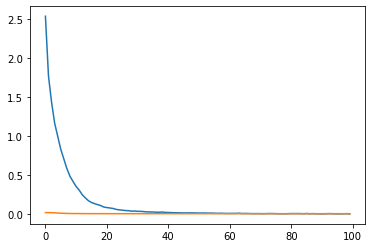

In [153]:
# training setup
learningRate=0.00005
nEpoch=30

optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
loss_fn = nn.CrossEntropyLoss()

#Logging
params = {"learning_rate": learningRate, "optimizer": "Adam"}
run['params'] = params
run['model'] = model
run['data'] = '80-10-10 split with 1000 samples, no data augmentation'


train_acc = []
valid_acc = []
losses = []
valid_loss = []

# start training the model

accuracy=np.zeros(nEpoch)
loss_vec=np.zeros(nEpoch)
for iEpoch in range(nEpoch):
    model.to(device)
    cur_loss = 0
    model.train()
    
    trainEstimatedLabels=np.empty((0,))
    trainTrueLabels=np.empty((0,))
    valEstimatedLabels=np.empty((0,))
    valTrueLabels=np.empty((0,))
    
    for im, lab in trainloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)
        
        loss=loss_fn(y_pred,lab.long())
        
        # zero the gradients before running the backward pass
        model.zero_grad()
        loss.backward()
        optimizer.step()
        cur_loss += loss.float() 
    losses.append(cur_loss.cpu().detach().numpy() / len(trainloader))
    
    model.eval()
    with torch.no_grad():
        for im, lab in trainloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)

            yhat=y_pred.argmax(dim=1)
            trainEstimatedLabels=np.append(trainEstimatedLabels,yhat.cpu())
            trainTrueLabels=np.append(trainTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)


        for im, lab in valloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)
            val_loss=loss_fn(y_pred,lab.long())

            # calculate accuracy for whole training set
            yhat=y_pred.argmax(dim=1)
            valEstimatedLabels=np.append(valEstimatedLabels,yhat.cpu())
            valTrueLabels=np.append(valTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)
        valid_loss.append(val_loss.cpu().detach().numpy() / batch_size)

        # calculate accuracy for whole training set
        #accuracy[iEpoch]=np.mean(estimatedLabels==trueLabels)
        #loss_vec[iEpoch]=loss # last loss, could be average loss instead??

        #Calculate accuracies
        train_acc_cur = accuracy_score(trainTrueLabels, trainEstimatedLabels)
        valid_acc_cur = accuracy_score(valTrueLabels, valEstimatedLabels)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)


        #Plot output
        if iEpoch % 1 == 0:
            print("Epoch %2i : Train Loss %f , Val Loss %f, Train acc %f, Valid acc %f" % (
                    iEpoch+1, losses[-1], valid_loss[-1], train_acc_cur, valid_acc_cur))
            run['Train Loss'].log(losses[-1]) 
            run['Train acc'].log(train_acc_cur)
            run['valid_acc_cur'].log(valid_acc_cur)
        
# print accuracy and loss
#print("Train accuracy:", accuracy[-1:])
#print("Loss:", loss_vec[-1:])
run['losses'] = losses
run['valid_loss'] = valid_loss
plt.plot(losses)
plt.plot(valid_loss)
plt.show()

In [154]:
run['losses'] = losses
run['valid_loss'] = valid_loss
run['train_acc'] = train_acc
run['valid_acc'] = valid_acc

In [ ]:
cm_pred = []
cm_true = []
testEstimatedLabels=np.empty((0,))
testTrueLabels=np.empty((0,))
with torch.no_grad():
    for im, lab in testloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)

        # calculate accuracy for whole training set
        yhat=y_pred.argmax(dim=1)
        testEstimatedLabels=np.append(testEstimatedLabels,yhat.cpu())
        testTrueLabels=np.append(testTrueLabels,lab.cpu())
        
    valid_acc_cur = accuracy_score(testTrueLabels, testEstimatedLabels)
    
cm_pred = np.append(cm_pred, testEstimatedLabels)
cm_true = np.append(cm_true, testTrueLabels)

cm = sklearn.metrics.confusion_matrix(cm_true, cm_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.xaxis.set_ticklabels([*dataset.class_to_idx])
ax.yaxis.set_ticklabels([*dataset.class_to_idx])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.gcf().set_size_inches(15, 8)
plt.show()

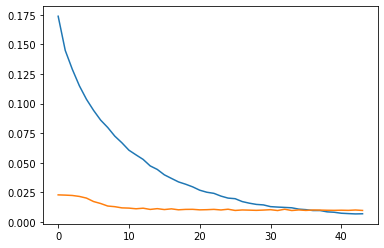

In [95]:
plt.plot(losses)
plt.plot(valid_loss)
plt.show()

In [155]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


# Pipeline for adding transposed data

In [82]:
dataset = torchaudio.datasets.GTZAN(root = 'Data') #Using Torchaudio inbuilt dataloader. 
train, val, test = random_split(dataset, [800, 100, 100], generator=torch.Generator().manual_seed(42))

def pitch_shift(dataset, img_path):
    for i, data in enumerate(dataset):
        waveform, sample_rate, label = data
        pathlib.Path(f'{img_path}/{label}').mkdir(parents=True, exist_ok=True)
        pitch = np.random.choice([-9,-8,-7,-6,-5,5,6,7,8,9]) #Some somewhat sensible pitch shifts
        waveform = librosa.effects.pitch_shift(waveform.numpy()[0], sample_rate, n_steps=pitch)
        spec = librosa.feature.melspectrogram(waveform, sr=sample_rate, n_fft = 2048, win_length=2048, n_mels=90, hop_length=1024)
        spec = librosa.power_to_db(spec)
        librosa.display.specshow(spec,sr=sample_rate,cmap="coolwarm")
        plt.axis('off');
        plt.savefig(f'{img_path}/{label}/{label}000{i}shifted.png', bbox_inches = 'tight') #bbox removes white border
        plt.clf() #Generate and save in the same way as make_libmelspecs

In [83]:
pitch_shift(train, 'train/30secs_shifted')

<Figure size 432x288 with 0 Axes>

In [134]:
resize = 224
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((resize,resize)), 
                                            torchvision.transforms.ToTensor(),])
train_shift = torchvision.datasets.ImageFolder(root = 'train/30secs_shifted', transform=transform)

save_tensors(train_shift, 'train/30secs_shifted/tensors')

In [135]:
train_path = 'train/30secs/tensors'
val_path = 'val/30secs/tensors'
test_path = 'test/30secs/tensors'
train_shift_path = 'train/30secs_shifted/tensors'


train = Spectrogram_dataset(train_path)
train_shift = Spectrogram_dataset(train_path)
val = Spectrogram_dataset(val_path)
test = Spectrogram_dataset(test_path)

print(len(train))
print(len(train_shift))
print(len(val))
print(len(test))

800
800
100
100


In [139]:
import neptune.new as neptune
run = neptune.init(
    project="mgc-tora/mgctora",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDhhMWMyNy05YTZlLTRiM2EtYjgzYi1lYTFhZmZlZmNjMzkifQ==",
)  # your credentials

https://app.neptune.ai/mgc-tora/mgctora/e/MGCTOR-57
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# CNN with 1800 samples augmented

In [140]:
train = torch.utils.data.ConcatDataset((train, train_shift)) #Combining shifted and normal train tensors

In [141]:
batch_size = 100
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test, batch_size=batch_size, shuffle=True)
#[batchsize, channels, height, width], label

In [142]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=12)
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(in_features=12*53*53, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1, 12*53*53)
        x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

model = Net()

print('Network architecture:\n')
print(model)

# Print parameter shapes
print('Network parameters:\n')
for name, param in model.named_parameters(): 
    print('parameter',name,param.shape)
    
model.to(device)

Network architecture:

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=33708, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=10, bias=True)
)
Network parameters:

parameter conv1.weight torch.Size([6, 3, 5, 5])
parameter conv1.bias torch.Size([6])
parameter bn1.weight torch.Size([6])
parameter bn1.bias torch.Size([6])
parameter conv2.weight torch.Size([12, 6, 5, 5])
parameter conv2.bias torch.Size([12])
parameter bn2.weight torch.Size([12])
parameter bn2.bias torch.Size([12])
parameter fc1.weight torch.Size([1028, 33708])
parameter fc1.bias torch.Size([1028]

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=33708, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=10, bias=True)
)

In [159]:
run = neptune.init(
    project="mgc-tora/Final-runs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDhhMWMyNy05YTZlLTRiM2EtYjgzYi1lYTFhZmZlZmNjMzkifQ==",
) 

https://app.neptune.ai/mgc-tora/Final-runs/e/FIN-9
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [143]:
def accuracy_score(targets, predictions):
    return 1.0*np.sum((np.array(targets) == np.array(predictions)))/len(targets)

In [ ]:
# training setup
learningRate=0.00005
nEpoch=30

optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
loss_fn = nn.CrossEntropyLoss()

#Logging
params = {"learning_rate": learningRate, "optimizer": "Adam"}
run['params'] = params
run['model'] = model


train_acc = []
valid_acc = []
losses = []
valid_loss = []

# start training the model

accuracy=np.zeros(nEpoch)
loss_vec=np.zeros(nEpoch)
for iEpoch in range(nEpoch):
    model.to(device)
    cur_loss = 0
    model.train()
    
    trainEstimatedLabels=np.empty((0,))
    trainTrueLabels=np.empty((0,))
    valEstimatedLabels=np.empty((0,))
    valTrueLabels=np.empty((0,))
    
    for im, lab in trainloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)
        
        loss=loss_fn(y_pred,lab.long())
        
        # zero the gradients before running the backward pass
        model.zero_grad()
        loss.backward()
        optimizer.step()
        cur_loss += loss.float()
    losses.append(cur_loss.cpu().detach().numpy() / len(trainloader)
    
    model.eval()
    with torch.no_grad():
        for im, lab in trainloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)

            yhat=y_pred.argmax(dim=1)
            trainEstimatedLabels=np.append(trainEstimatedLabels,yhat.cpu())
            trainTrueLabels=np.append(trainTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)


        for im, lab in valloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)
            val_loss=loss_fn(y_pred,lab.long())

            # calculate accuracy for whole training set
            yhat=y_pred.argmax(dim=1)
            valEstimatedLabels=np.append(valEstimatedLabels,yhat.cpu())
            valTrueLabels=np.append(valTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)
        valid_loss.append(val_loss.cpu().detach().numpy() / batch_size)

        # calculate accuracy for whole training set
        #accuracy[iEpoch]=np.mean(estimatedLabels==trueLabels)
        #loss_vec[iEpoch]=loss # last loss, could be average loss instead??

        #Calculate accuracies
        train_acc_cur = accuracy_score(trainTrueLabels, trainEstimatedLabels)
        valid_acc_cur = accuracy_score(valTrueLabels, valEstimatedLabels)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)


        #Plot output
        if iEpoch % 1 == 0:
            print("Epoch %2i : Train Loss %f , Val Loss %f, Train acc %f, Valid acc %f" % (
                    iEpoch+1, losses[-1], valid_loss[-1], train_acc_cur, valid_acc_cur))
            #run['Train Loss'].log(losses[-1]) 
            #run['Train acc'].log(train_acc_cur)
            #run['valid_acc_cur'].log(valid_acc_cur)
        
# print accuracy and loss
#print("Train accuracy:", accuracy[-1:])
#print("Loss:", loss_vec[-1:])

print(losses[-1])

plt.plot(losses)
plt.plot(valid_loss)
plt.show()

In [145]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


# Increasing sample size

In [105]:
chunk_size = 5
def mel_spec_more_samples(dataset, img_path):
    for i, data in enumerate(dataset):
        waveform, sample_rate, label = data #tensor, int, label = genre
        pathlib.Path(f'{img_path}/{label}').mkdir(parents=True, exist_ok=True) #making directories
        for idx, split in enumerate(torch.chunk(waveform[0], chunk_size)): #splitting each waveform into chunk_size
            spec = librosa.feature.melspectrogram(split.numpy(), sr=sample_rate, n_fft = 2048, win_length=2048, n_mels=90, hop_length=1024)
            spec = librosa.power_to_db(spec)
            librosa.display.specshow(spec,sr=sample_rate,cmap="coolwarm")
            plt.axis('off');
            plt.savefig(f'{img_path}/{label}/{label}{i}{idx}.png', bbox_inches = 'tight') #bbox removes white border
            plt.clf() #Generate and save in the same way as make_libmelspecs

In [106]:
dataset = torchaudio.datasets.GTZAN(root = 'Data') #Using Torchaudio inbuilt dataloader. 
train, val, test = random_split(dataset, [800, 100, 100], generator=torch.Generator().manual_seed(42))
mel_spec_more_samples(train, 'train/6secs')
mel_spec_more_samples(val, 'val/6secs')
mel_spec_more_samples(test, 'test/6secs')

<Figure size 432x288 with 0 Axes>

In [140]:
import neptune.new as neptune
run = neptune.init(
    project="mgc-tora/mgctora",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDhhMWMyNy05YTZlLTRiM2EtYjgzYi1lYTFhZmZlZmNjMzkifQ==",
)  # your credentials

https://app.neptune.ai/mgc-tora/mgctora/e/MGCTOR-34
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [157]:
train_path = 'train/6secs'
val_path = 'val/6secs'
test_path = 'test/6secs'
resize = 224
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((resize,resize)), 
                                            torchvision.transforms.ToTensor(),])


dataset = torchvision.datasets.ImageFolder(root = img_path, transform=transform)
train = torchvision.datasets.ImageFolder(root = train_path, transform=transform)
val = torchvision.datasets.ImageFolder(root = val_path, transform=transform)
test = torchvision.datasets.ImageFolder(root = test_path, transform=transform)

train_path = 'train/6secs/tensors'
val_path = 'val/6secs/tensors'
test_path = 'test/6secs/tensors'

save_tensors(train, train_path)
save_tensors(val, val_path)
save_tensors(test, test_path)

In [158]:
train = Spectrogram_dataset(train_path)
val = Spectrogram_dataset(val_path)
test = Spectrogram_dataset(test_path)

print(len(train))
print(len(val))
print(len(test))

4000
500
500


In [160]:
batch_size = 100
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test, batch_size=batch_size, shuffle=True)
#[batchsize, channels, height, width], label

In [151]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=12)
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(in_features=12*53*53, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1, 12*53*53)
        x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

model = Net()

print('Network architecture:\n')
print(model)

# Print parameter shapes
print('Network parameters:\n')
for name, param in model.named_parameters(): 
    print('parameter',name,param.shape)
    
model.to(device)

Network architecture:

Net(
  (conv1): Conv2d(3, 6, kernel_size=(10, 3), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=5280, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Network parameters:

parameter conv1.weight torch.Size([6, 3, 10, 3])
parameter conv1.bias torch.Size([6])
parameter bn1.weight torch.Size([6])
parameter bn1.bias torch.Size([6])
parameter conv2.weight torch.Size([12, 6, 5, 5])
parameter conv2.bias torch.Size([12])
parameter bn2.weight torch.Size([12])
parameter bn2.bias torch.Size([12])
parameter fc1.weight torch.Size([512, 5280])
parameter fc1.bias torch.Size([512])
pa

Net(
  (conv1): Conv2d(3, 6, kernel_size=(10, 3), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=5280, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
run = neptune.init(
    project="mgc-tora/Final-runs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDhhMWMyNy05YTZlLTRiM2EtYjgzYi1lYTFhZmZlZmNjMzkifQ==",
) 

# CNN with 5000 samples unaugmented

In [ ]:
# training setup
learningRate=0.00005
nEpoch=30

optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
loss_fn = nn.CrossEntropyLoss()

#Logging
params = {"learning_rate": learningRate, "optimizer": "Adam"}
run['params'] = params
run['model'] = model
run['data'] = '80-10-10 split with 5000 samples, no data augmentation'


train_acc = []
valid_acc = []
losses = []
valid_loss = []

# start training the model

accuracy=np.zeros(nEpoch)
loss_vec=np.zeros(nEpoch)
for iEpoch in range(nEpoch):
    model.to(device)
    cur_loss = 0
    model.train()
    
    trainEstimatedLabels=np.empty((0,))
    trainTrueLabels=np.empty((0,))
    valEstimatedLabels=np.empty((0,))
    valTrueLabels=np.empty((0,))
    
    for im, lab in trainloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)
        
        loss=loss_fn(y_pred,lab.long())
        
        # zero the gradients before running the backward pass
        model.zero_grad()
        loss.backward()
        optimizer.step()
        cur_loss += loss.float() 
    losses.append(cur_loss.cpu().detach().numpy() / len(trainloader))
    
    model.eval()
    with torch.no_grad():
        for im, lab in trainloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)

            yhat=y_pred.argmax(dim=1)
            trainEstimatedLabels=np.append(trainEstimatedLabels,yhat.cpu())
            trainTrueLabels=np.append(trainTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)


        for im, lab in valloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)
            val_loss=loss_fn(y_pred,lab.long())

            # calculate accuracy for whole training set
            yhat=y_pred.argmax(dim=1)
            valEstimatedLabels=np.append(valEstimatedLabels,yhat.cpu())
            valTrueLabels=np.append(valTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)
        valid_loss.append(val_loss.cpu().detach().numpy() / batch_size)

        # calculate accuracy for whole training set
        #accuracy[iEpoch]=np.mean(estimatedLabels==trueLabels)
        #loss_vec[iEpoch]=loss # last loss, could be average loss instead??

        #Calculate accuracies
        train_acc_cur = accuracy_score(trainTrueLabels, trainEstimatedLabels)
        valid_acc_cur = accuracy_score(valTrueLabels, valEstimatedLabels)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)


        #Plot output
        if iEpoch % 1 == 0:
            print("Epoch %2i : Train Loss %f , Val Loss %f, Train acc %f, Valid acc %f" % (
                    iEpoch+1, losses[-1], valid_loss[-1], train_acc_cur, valid_acc_cur))
            run['Train Loss'].log(losses[-1]) 
            run['Train acc'].log(train_acc_cur)
            run['valid_acc_cur'].log(valid_acc_cur)
        
# print accuracy and loss
#print("Train accuracy:", accuracy[-1:])
#print("Loss:", loss_vec[-1:])
run['losses'] = losses
run['valid_loss'] = valid_loss
plt.plot(losses)
plt.plot(valid_loss)
plt.show()

In [ ]:
run['losses'] = losses
run['valid_loss'] = valid_loss
run['train_acc'] = train_acc
run['valid_acc'] = valid_acc

## DenseNet script as it was run on kaggle
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader, Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn
import seaborn as sns
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Spectrogram_dataset(Dataset):
    def __init__(self, folder, transform=None): # Path to folder
        self.img_dir = folder + '/images'
        self.lab_dir = folder + '/labels'
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir)) #Just the amount of elements in either directory

    def __getitem__(self, idx):
        lst_img = sorted(os.listdir(self.img_dir)) #Files are named in same manner, so sorting should give same indices.
        lst_label = sorted(os.listdir(self.lab_dir))

        img_file_path = os.path.join(self.img_dir, lst_img[idx])
        img_tensor = torch.load(img_file_path)

        label_file_path = os.path.join(self.lab_dir, lst_label[idx])
        label = torch.load(label_file_path)

        return img_tensor, label

In [ ]:
train_path = '../input/224x224tensors/train/30secs/tensors'
val_path = '../input/224x224tensors/val/30secs/tensors'
test_path = '../input/224x224tensors/test/30secs/tensors'


train = Spectrogram_dataset(train_path)
val = Spectrogram_dataset(val_path)
test = Spectrogram_dataset(test_path)


#uncomment to not use pitch shift
#train = torch.utils.data.ConcatDataset((train, train_shift)) #Combining shifted and normal train tensors

batch_size = 100
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test, batch_size=batch_size, shuffle=True)

#[batchsize, channels, height, width], label

print(len(train))
print(len(val))
print(len(test))

In [ ]:
model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)

In [ ]:
!pip install neptune-client
import neptune.new as neptune

run = neptune.init(
    project="mgc-tora/Final-runs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDhhMWMyNy05YTZlLTRiM2EtYjgzYi1lYTFhZmZlZmNjMzkifQ==",
) 

In [ ]:
# training setup
def accuracy_score(targets, predictions):
    return 1.0*np.sum((np.array(targets) == np.array(predictions)))/len(targets)
learningRate=0.00005
nEpoch=30

optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
loss_fn = nn.CrossEntropyLoss()

#Logging
params = {"learning_rate": learningRate, "optimizer": "Adam"}
run['params'] = params
run['model'] = 'DenseNet121-not trained'
run['data'] = '80-10-10 split with 1000 samples, no data augmentation'


train_acc = []
valid_acc = []
losses = []
valid_loss = []

# start training the model

accuracy=np.zeros(nEpoch)
loss_vec=np.zeros(nEpoch)
for iEpoch in range(nEpoch):
    model.to(device)
    cur_loss = 0
    model.train()
    
    trainEstimatedLabels=np.empty((0,))
    trainTrueLabels=np.empty((0,))
    valEstimatedLabels=np.empty((0,))
    valTrueLabels=np.empty((0,))
    
    for im, lab in trainloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)
        
        loss=loss_fn(y_pred,lab.long())
        
        # zero the gradients before running the backward pass
        model.zero_grad()
        loss.backward()
        optimizer.step()
        cur_loss += loss.float() 
    losses.append(cur_loss.cpu().detach().numpy() / len(trainloader))
    
    model.eval()
    with torch.no_grad():
        for im, lab in trainloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)

            yhat=y_pred.argmax(dim=1)
            trainEstimatedLabels=np.append(trainEstimatedLabels,yhat.cpu())
            trainTrueLabels=np.append(trainTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)


        for im, lab in valloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)
            val_loss=loss_fn(y_pred,lab.long())

            # calculate accuracy for whole training set
            yhat=y_pred.argmax(dim=1)
            valEstimatedLabels=np.append(valEstimatedLabels,yhat.cpu())
            valTrueLabels=np.append(valTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)
        valid_loss.append(val_loss.cpu().detach().numpy() / batch_size)

        # calculate accuracy for whole training set
        #accuracy[iEpoch]=np.mean(estimatedLabels==trueLabels)
        #loss_vec[iEpoch]=loss # last loss, could be average loss instead??

        #Calculate accuracies
        train_acc_cur = accuracy_score(trainTrueLabels, trainEstimatedLabels)
        valid_acc_cur = accuracy_score(valTrueLabels, valEstimatedLabels)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)


        #Plot output
        if iEpoch % 1 == 0:
            if valid_loss[-1] <= np.min(valid_loss):
                torch.save(model.state_dict(), './DenseNet1000samples')
            print("Epoch %2i : Train Loss %f , Val Loss %f, Train acc %f, Valid acc %f" % (
                    iEpoch+1, losses[-1], valid_loss[-1], train_acc_cur, valid_acc_cur))
            run['Train Loss'].log(losses[-1]) 
            run['Train acc'].log(train_acc_cur)
            run['valid_acc_cur'].log(valid_acc_cur)
        
# print accuracy and loss
#print("Train accuracy:", accuracy[-1:])
#print("Loss:", loss_vec[-1:])
run['losses'] = losses
run['valid_loss'] = valid_loss
plt.plot(losses)
plt.plot(valid_loss)
plt.show()

In [ ]:
run['losses'] = losses
run['valid_loss'] = valid_loss
run['train_acc'] = train_acc
run['valid_acc'] = valid_acc

In [ ]:
model.load_state_dict(torch.load('./DenseNet1000samples'))
cm_pred = []
cm_true = []
testEstimatedLabels=np.empty((0,))
testTrueLabels=np.empty((0,))
model.eval()
with torch.no_grad():
    for im, lab in testloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)

        # calculate accuracy for whole training set
        yhat=y_pred.argmax(dim=1)
        testEstimatedLabels=np.append(testEstimatedLabels,yhat.cpu())
        testTrueLabels=np.append(testTrueLabels,lab.cpu())
        
    valid_acc_cur = accuracy_score(testTrueLabels, testEstimatedLabels)
run['test_accuracy'] = valid_acc_cur
cm_pred = np.append(cm_pred, testEstimatedLabels)
cm_true = np.append(cm_true, testTrueLabels)

cm = sklearn.metrics.confusion_matrix(cm_true, cm_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
#ax.xaxis.set_ticklabels([*dataset.class_to_idx])
#ax.yaxis.set_ticklabels([*dataset.class_to_idx])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.gcf().set_size_inches(15, 8)
plt.show()

In [ ]:
run.stop()

In [ ]:
from IPython.display import FileLink
FileLink('./DenseNet1000samples') 

In [ ]:
train_path = '../input/224x224tensors/train/30secs/tensors'
val_path = '../input/224x224tensors/val/30secs/tensors'
test_path = '../input/224x224tensors/test/30secs/tensors'
train_shift_path = '../input/224x224tensors/train/30secs_shifted/tensors'
train = Spectrogram_dataset(train_path)
val = Spectrogram_dataset(val_path)
test = Spectrogram_dataset(test_path)
train_shift = Spectrogram_dataset(train_shift_path)

train = torch.utils.data.ConcatDataset((train, train_shift)) #Combining shifted and normal train tensors

batch_size = 100
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test, batch_size=batch_size, shuffle=True)

#[batchsize, channels, height, width], label

print(len(train))
print(len(train_shift))
print(len(val))
print(len(test))

In [ ]:
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)
run = neptune.init(
    project="mgc-tora/Final-runs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDhhMWMyNy05YTZlLTRiM2EtYjgzYi1lYTFhZmZlZmNjMzkifQ==",
) 

In [ ]:
# training setup
def accuracy_score(targets, predictions):
    return 1.0*np.sum((np.array(targets) == np.array(predictions)))/len(targets)
learningRate=0.00005
nEpoch=30

optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
loss_fn = nn.CrossEntropyLoss()

#Logging
params = {"learning_rate": learningRate, "optimizer": "Adam"}
run['params'] = params
run['model'] = 'DenseNet121-pretrained'
run['data'] = '80-10-10 split with 1800 samples, with data augmentation'


train_acc = []
valid_acc = []
losses = []
valid_loss = []

# start training the model

accuracy=np.zeros(nEpoch)
loss_vec=np.zeros(nEpoch)
for iEpoch in range(nEpoch):
    model.to(device)
    cur_loss = 0
    model.train()
    
    trainEstimatedLabels=np.empty((0,))
    trainTrueLabels=np.empty((0,))
    valEstimatedLabels=np.empty((0,))
    valTrueLabels=np.empty((0,))
    
    for im, lab in trainloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)
        
        loss=loss_fn(y_pred,lab.long())
        
        # zero the gradients before running the backward pass
        model.zero_grad()
        loss.backward()
        optimizer.step()
        cur_loss += loss.float() 
    losses.append(cur_loss.cpu().detach().numpy() / len(trainloader))
    
    model.eval()
    with torch.no_grad():
        for im, lab in trainloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)

            yhat=y_pred.argmax(dim=1)
            trainEstimatedLabels=np.append(trainEstimatedLabels,yhat.cpu())
            trainTrueLabels=np.append(trainTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)


        for im, lab in valloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)
            val_loss=loss_fn(y_pred,lab.long())

            # calculate accuracy for whole training set
            yhat=y_pred.argmax(dim=1)
            valEstimatedLabels=np.append(valEstimatedLabels,yhat.cpu())
            valTrueLabels=np.append(valTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)
        valid_loss.append(val_loss.cpu().detach().numpy() / batch_size)

        # calculate accuracy for whole training set
        #accuracy[iEpoch]=np.mean(estimatedLabels==trueLabels)
        #loss_vec[iEpoch]=loss # last loss, could be average loss instead??

        #Calculate accuracies
        train_acc_cur = accuracy_score(trainTrueLabels, trainEstimatedLabels)
        valid_acc_cur = accuracy_score(valTrueLabels, valEstimatedLabels)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)


        #Plot output
        if iEpoch % 1 == 0:
            if valid_loss[-1] <= np.min(valid_loss):
                torch.save(model.state_dict(), './DenseNet1800samples_augmented')
            print("Epoch %2i : Train Loss %f , Val Loss %f, Train acc %f, Valid acc %f" % (
                    iEpoch+1, losses[-1], valid_loss[-1], train_acc_cur, valid_acc_cur))
            run['Train Loss'].log(losses[-1]) 
            run['Train acc'].log(train_acc_cur)
            run['valid_acc_cur'].log(valid_acc_cur)
        
# print accuracy and loss
#print("Train accuracy:", accuracy[-1:])
#print("Loss:", loss_vec[-1:])
run['losses'] = losses
run['valid_loss'] = valid_loss
plt.plot(losses)
plt.plot(valid_loss)
plt.show()

In [ ]:
model.load_state_dict(torch.load('./DenseNet1800samples_augmented'))
cm_pred = []
cm_true = []
testEstimatedLabels=np.empty((0,))
testTrueLabels=np.empty((0,))
model.eval()
with torch.no_grad():
    for im, lab in testloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)

        # calculate accuracy for whole training set
        yhat=y_pred.argmax(dim=1)
        testEstimatedLabels=np.append(testEstimatedLabels,yhat.cpu())
        testTrueLabels=np.append(testTrueLabels,lab.cpu())
        
    valid_acc_cur = accuracy_score(testTrueLabels, testEstimatedLabels)
run['test_accuracy'] = valid_acc_cur
cm_pred = np.append(cm_pred, testEstimatedLabels)
cm_true = np.append(cm_true, testTrueLabels)

cm = sklearn.metrics.confusion_matrix(cm_true, cm_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
#ax.xaxis.set_ticklabels([*dataset.class_to_idx])
#ax.yaxis.set_ticklabels([*dataset.class_to_idx])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.gcf().set_size_inches(15, 8)
plt.show()

In [ ]:
run['losses'] = train_loss
run['valid_loss'] = val_loss
run['train_acc'] = train_acc
run['valid_acc'] = val_acc

In [ ]:
from IPython.display import FileLink
FileLink('./DenseNet1800samples_augmented') 

In [ ]:
run.stop()

In [ ]:
train_path = '../input/224x224tensors/train/6secs/tensors'
val_path = '../input/224x224tensors/val/6secs/tensors'
test_path = '../input/224x224tensors/test/6secs/tensors'
train = Spectrogram_dataset(train_path)
val = Spectrogram_dataset(val_path)
test = Spectrogram_dataset(test_path)

batch_size = 100
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test, batch_size=batch_size, shuffle=True)

#[batchsize, channels, height, width], label

print(len(train))
print(len(val))
print(len(test))

In [ ]:
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)
run = neptune.init(
    project="mgc-tora/Final-runs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDhhMWMyNy05YTZlLTRiM2EtYjgzYi1lYTFhZmZlZmNjMzkifQ==",
) 

In [ ]:
run = neptune.init(
    project="mgc-tora/Final-runs",
    run = 'FIN-23',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZDhhMWMyNy05YTZlLTRiM2EtYjgzYi1lYTFhZmZlZmNjMzkifQ==",
) 

In [ ]:
# training setup
def accuracy_score(targets, predictions):
    return 1.0*np.sum((np.array(targets) == np.array(predictions)))/len(targets)
learningRate=0.00005
nEpoch=30

optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
loss_fn = nn.CrossEntropyLoss()

#Logging
params = {"learning_rate": learningRate, "optimizer": "Adam"}
run['params'] = params
run['model'] = 'DenseNet121-pretrained'
run['data'] = '80-10-10 split with 5000 samples, without data augmentation'


train_acc = []
valid_acc = []
losses = []
valid_loss = []

# start training the model

accuracy=np.zeros(nEpoch)
loss_vec=np.zeros(nEpoch)
for iEpoch in range(nEpoch):
    model.to(device)
    cur_loss = 0
    model.train()
    
    trainEstimatedLabels=np.empty((0,))
    trainTrueLabels=np.empty((0,))
    valEstimatedLabels=np.empty((0,))
    valTrueLabels=np.empty((0,))
    
    for im, lab in trainloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)
        
        loss=loss_fn(y_pred,lab.long())
        
        # zero the gradients before running the backward pass
        model.zero_grad()
        loss.backward()
        optimizer.step()
        cur_loss += loss.float() 
    losses.append(cur_loss.cpu().detach().numpy() / len(trainloader))
    
    model.eval()
    with torch.no_grad():
        for im, lab in trainloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)

            yhat=y_pred.argmax(dim=1)
            trainEstimatedLabels=np.append(trainEstimatedLabels,yhat.cpu())
            trainTrueLabels=np.append(trainTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)


        for im, lab in valloader:
            im = im.to(device)
            lab = lab.to(device)
            y_pred=model(im)
            val_loss=loss_fn(y_pred,lab.long())

            # calculate accuracy for whole training set
            yhat=y_pred.argmax(dim=1)
            valEstimatedLabels=np.append(valEstimatedLabels,yhat.cpu())
            valTrueLabels=np.append(valTrueLabels,lab.cpu())

            #print(y_pred.argmax(dim = 1))
            #print(lab)
        valid_loss.append(val_loss.cpu().detach().numpy() / batch_size)

        # calculate accuracy for whole training set
        #accuracy[iEpoch]=np.mean(estimatedLabels==trueLabels)
        #loss_vec[iEpoch]=loss # last loss, could be average loss instead??

        #Calculate accuracies
        train_acc_cur = accuracy_score(trainTrueLabels, trainEstimatedLabels)
        valid_acc_cur = accuracy_score(valTrueLabels, valEstimatedLabels)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)


        #Plot output
        if iEpoch % 1 == 0:
            if valid_loss[-1] <= np.min(valid_loss):
                torch.save(model.state_dict(), './DenseNet5000samples')
            print("Epoch %2i : Train Loss %f , Val Loss %f, Train acc %f, Valid acc %f" % (
                    iEpoch+1, losses[-1], valid_loss[-1], train_acc_cur, valid_acc_cur))
            run['Train Loss'].log(losses[-1]) 
            run['Train acc'].log(train_acc_cur)
            run['valid_acc_cur'].log(valid_acc_cur)
        
# print accuracy and loss
#print("Train accuracy:", accuracy[-1:])
#print("Loss:", loss_vec[-1:])
run['losses'] = losses
run['valid_loss'] = valid_loss
plt.plot(losses)
plt.plot(valid_loss)
plt.show()

In [ ]:
run['losses'] = losses
run['valid_loss'] = valid_loss
run['train_acc'] = train_acc
run['valid_acc'] = valid_acc

In [ ]:
import scikitplot
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)
model.to(device)
model.load_state_dict(torch.load('./DenseNet5000samples'))
cm_pred = []
cm_true = []
testEstimatedLabels=np.empty((0,))
testTrueLabels=np.empty((0,))
model.eval()
with torch.no_grad():
    for im, lab in testloader:
        im = im.to(device)
        lab = lab.to(device)
        y_pred=model(im)

        # calculate accuracy for whole training set
        yhat=y_pred.argmax(dim=1)
        testEstimatedLabels=np.append(testEstimatedLabels,yhat.cpu())
        testTrueLabels=np.append(testTrueLabels,lab.cpu())
        
    valid_acc_cur = accuracy_score(testTrueLabels, testEstimatedLabels)
#run['test_accuracy'] = valid_acc_cur
print(valid_acc_cur)

cm_pred = np.append(cm_pred, testEstimatedLabels)
cm_true = np.append(cm_true, testTrueLabels)

cm = scikitplot.metrics.confusion_matrix(cm_true, cm_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
#ax.xaxis.set_ticklabels([*dataset.class_to_idx])
#ax.yaxis.set_ticklabels([*dataset.class_to_idx])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
data_classes = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
cm = scikitplot.metrics.confusion_matrix(cm_true, cm_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues',annot_kws={"fontsize":15})
ax.xaxis.set_ticklabels([*data_classes])
ax.yaxis.set_ticklabels([*data_classes])
plt.gcf().set_size_inches(15, 20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
#sns.set(font_scale=2)

plt.show()

In [ ]:
from IPython.display import FileLink
FileLink('./DenseNet5000samples') 

In [ ]:
run.stop()